In [2]:
import jax.numpy as jnp
from pyutils.jax.differential import *
import matplotlib.pyplot as plt

## Brownian with reset

$$dx_t = \mu dt+\sigma dW_t$$

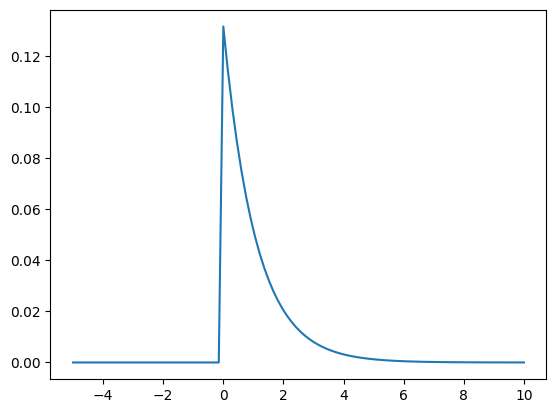

In [79]:
n = 100
x = jnp.linspace(-5,10,n)

mu = 0.1
sigma = 0.5*0
chi = 0.1

g_entry = jnp.zeros(n)
i = jnp.searchsorted(x, 0)
x_entry = 0
g_entry = g_entry.at[i].set((x_entry -x[i-1])/(x[i]-x[i-1]))
g_entry = g_entry.at[i-1].set((x[i]-x_entry)/(x[i]-x[i-1]))
D_x = compute_backward_derivative(x, ghost_node=True) if mu >=0 else compute_forward_derivative(x, ghost_node=True)
D_xx = compute_second_derivative(x)
g = -jnp.linalg.solve((-D_x*mu - eye(n)*chi + 1/2*D_xx*sigma**2).todense(), chi*g_entry)
fig, ax = plt.subplots()
ax.plot(x,g)
plt.show()

# Ornstein–Uhlenbeck process


$$dx_t = -\theta x_t dt+\sigma dW_t$$

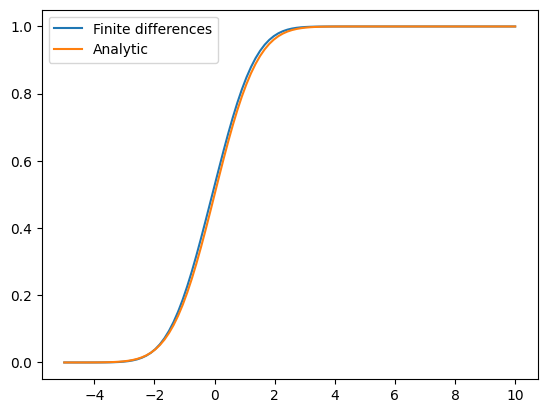

In [37]:
n = 100
x = jnp.linspace(-5,10,n)

theta = 0.1
sigma = 0.5

D_x_forward = compute_backward_derivative(x, ghost_node=True)
D_x_backward = compute_forward_derivative(x, ghost_node=True)
D_xx = compute_second_derivative(x)

mu_x = -theta*x

A = (-D_x_forward@spdiagm(jnp.where(mu_x<0, mu_x,0)) - D_x_backward@spdiagm(jnp.where(mu_x>0, mu_x,0)) + 1/2*D_xx*sigma**2).todense()
val, vec = jnp.linalg.eig(A)
g = vec[:,jnp.argmin(jnp.abs(val))]
if jnp.any(jnp.abs(g.imag)>1e-10):
    raise ValueError("Complex eigenvector found")
else:
    g = g.real
fig, ax = plt.subplots()
ax.plot(x, jnp.cumsum(g)/jnp.sum(g), label="Finite differences")
ax.plot(x, jax.scipy.stats.norm.cdf(x, 0, jnp.sqrt(sigma**2/(2*theta))), label='Analytic')
plt.legend()
plt.show()

# Cox-Ingersoll-Ross model

$$dx_t = a(b-x_t)+\sigma\sqrt{x}dW_t$$

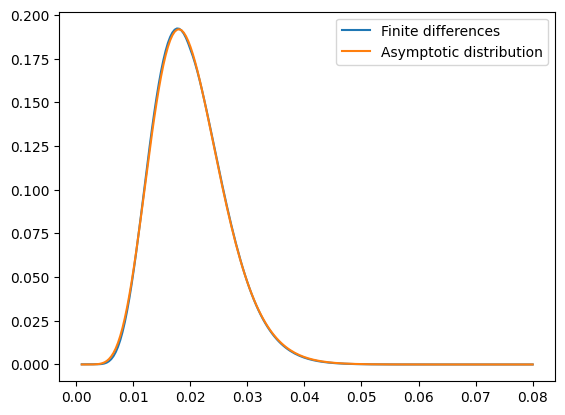

In [39]:
from jax.scipy.special import gamma

n = 200
x = jnp.linspace(0.001,0.08,n)

a = 0.1
b = 0.02
sigma = 0.02


D_x_forward = compute_backward_derivative(x, ghost_node=True)
D_x_backward = compute_forward_derivative(x, ghost_node=True)
D_xx = compute_second_derivative(x)

mu_x = a*(b-x)
sigma_x = sigma*jnp.sqrt(x)
beta = 2*a/sigma**2
alpha = 2*a*b/sigma**2
analitical_dist = beta**alpha/gamma(alpha)*x**(alpha-1)*jnp.exp(-beta*x)


A = (-D_x_forward@spdiagm(jnp.where(mu_x<0, mu_x, 0)) - D_x_backward@spdiagm(jnp.where(mu_x>0, mu_x, 0)) + 1/2*D_xx@spdiagm(sigma_x**2)).todense()
val, vec = jnp.linalg.eig(A)
g = vec[:,jnp.argmin(jnp.abs(val))]
g = -g if jnp.sum(g)<0 else g
if jnp.any(jnp.abs(g.imag)>1e-10):
    raise ValueError("Complex eigenvector found")
else:
    g = g.real
fig, ax = plt.subplots()
ax.plot(x, g, label="Finite differences")
ax.plot(x, analitical_dist*(jnp.sum(g)/jnp.sum(analitical_dist)), label='Asymptotic distribution')
plt.legend()
plt.show()

## Two dimensions

$$dx = \mu_x dt+\sigma_x dW_{x}$$
$$dy = \mu_y dt+\sigma_y dW_{y}$$
with $\text{Corr}(dW_x,dW_y)=\rho_{xy}$ and exit rate $\chi$

In [153]:
# function analytical(x,y, start=(0., 0.))
#     start = (1., 1.)
#     x0, y0 = start
#     return exit_rate/(pi*sigma_x*sigma_y*sqrt(1-rho_xy^2))*exp(-1/(1-rho_xy^2)*((x-x0)^2/sigma_x^2 - 2*rho_xy*(x-x0)*(y-y0)/(sigma_x*sigma_y) + (y-y0)^2/sigma_y^2))
# end

def analyitical(x,y, mu_x, mu_y, sigma_x, sigma_y, rho_xy, chi, x_entry, y_entry):
    coeff = chi/(jnp.pi*sigma_x*sigma_y*jnp.sqrt(1-rho_xy**2))
    exp_term = jnp.exp(-1/(1-rho_xy**2)*((x - x_entry)**2/sigma_x**2 - 2*rho_xy*(x - x_entry)*(y - y_entry)/(sigma_x*sigma_y) + (y - y_entry)**2/sigma_y**2))
    return coeff*exp_term

In [82]:
n_x, n_y = 50,51
x = jnp.linspace(-5,10, n_x)
y = jnp.linspace(-5,10, n_y)

D_x_forward = compute_D_x(x, y, "forward", ghost_node=True)
D_x_backward = compute_D_x(x, y, "backward", ghost_node=True)
D_y_forward = compute_D_y(x, y, "forward", ghost_node=True)
D_y_backward = compute_D_y(x, y, "backward", ghost_node=True)
D_xx = compute_D_xx(x, y)
D_yy = compute_D_yy(x, y)
D_xy = compute_D_xy(x, y)

In [149]:
mu_x = 0.
mu_y = 0.
sigma_x = 1
sigma_y = 0.6
rho_xy = -0.2
chi = 0.1
x_entry, y_entry = 0,0


g_entry = jnp.zeros((n_x, n_y))
i = jnp.searchsorted(x, x_entry)
j = jnp.searchsorted(y, y_entry)
g_entry = g_entry.at[i, j].set((x_entry -x[i-1])/(x[i]-x[i-1]) * (y_entry -y[j-1])/(y[j]-y[j-1]))
g_entry = g_entry.at[i-1, j].set((x[i]-x_entry)/(x[i]-x[i-1]) * (y_entry -y[j-1])/(y[j]-y[j-1]))
g_entry = g_entry.at[i, j-1].set((x_entry -x[i-1])/(x[i]-x[i-1]) * (y[j]-y_entry)/(y[j]-y[j-1]))
g_entry = g_entry.at[i-1, j-1].set((x[i]-x_entry)/(x[i]-x[i-1]) * (y[j]-y_entry)/(y[j]-y[j-1])) 

In [150]:
A = (-mu_x*D_x_backward - mu_y*D_y_backward -chi*speye(n_x*n_y)+ 1/2*(sigma_x**2*D_xx + sigma_y**2*D_yy + 2*rho_xy*sigma_x*sigma_y*D_xy)).todense()
g = jnp.linalg.solve(-A, chi*g_entry.flatten()).reshape((n_x, n_y))

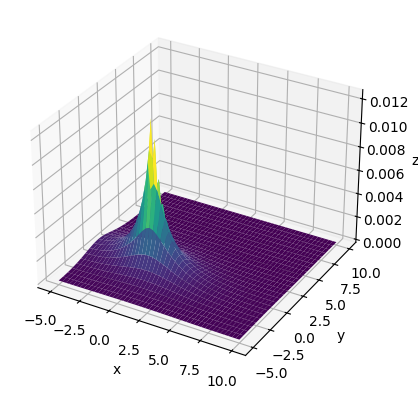

In [151]:
X, Y = jnp.meshgrid(x, y, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, g, cmap='viridis')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [156]:
g_analytical = analyitical(X, Y, mu_x, mu_y, sigma_x, sigma_y, rho_xy, chi, x_entry, y_entry)

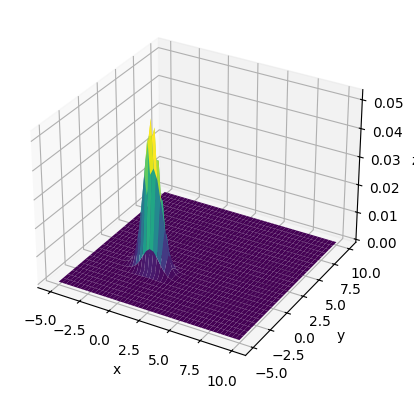

In [157]:
X, Y = jnp.meshgrid(x, y, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, g_analytical, cmap='viridis')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

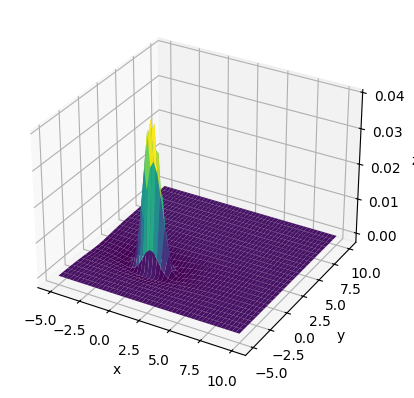

In [158]:
X, Y = jnp.meshgrid(x, y, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, g_analytical-g, cmap='viridis')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

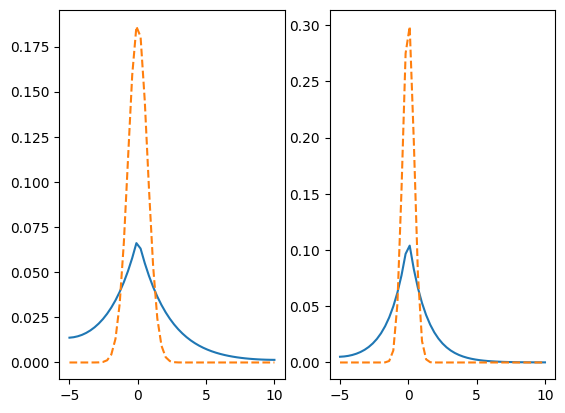

In [159]:
fig, ax = plt.subplots(ncols = 2)
ax[0].plot(x, jnp.sum(g, axis = 1))
ax[0].plot(x, jnp.sum(g_analytical, axis = 1), linestyle='dashed')
ax[1].plot(y, jnp.sum(g, axis = 0))
ax[1].plot(y, jnp.sum(g_analytical, axis = 0), linestyle='dashed')
plt.show()